#### Pré-Processamento de Dados de Texto Extraidos de Data Lake

In [1]:
from platform import python_version
print(python_version())

3.11.2


In [2]:
#!pip install -q pymongo

In [3]:
import json
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
%reload_ext watermark
%watermark --iversions

numpy     : 1.24.2
seaborn   : 0.12.2
pandas    : 1.5.3
json      : 2.0.9
matplotlib: 3.7.0
pymongo   : 4.3.3



In [5]:
client = pymongo.MongoClient('mongodb://localhost:27017')

In [6]:
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [7]:
datalake = client['datalake']

In [8]:
datalake

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'datalake')

In [9]:
datalake.posts.drop()

In [10]:
posts = datalake['posts']

In [11]:
posts

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'datalake'), 'posts')

In [12]:
with open('1-Projeto9/dados/dataset.json') as file:
    file_data = json.load(file)

In [13]:
file_data

[{'status': 'public',
  'creationDate': '2017-07-17T20:05:49Z',
  'allowComments': True,
  'title': 'ligula nec sem duis aliquam',
  'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
  'tags': 1,
  'Category': 'lifestyle',
  'filteredPicture': False},
 {'status': 'private',
  'creationDate': '2019-01-19T15:45:57Z',
  'allowComments': False,
  'title': 'mus vivamus vestibulum sagittis sapien cum',
  'description': 'nec nisi volutpat eleifend donec ut dolor morbi vel le

In [14]:
posts.insert_many(file_data, ordered = False, bypass_document_validation = True)

In [15]:
posts.find_one()

{'_id': ObjectId('643200da1b47b58598c9ef9d'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'ligula nec sem duis aliquam',
 'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False}

In [16]:
n = posts.estimated_document_count()

In [17]:
n

2000

In [18]:
posts_cat = posts.aggregate([{'$group': {'_id': '$Category', 'count': {'$sum':1}}},
                            {'$sort': {'_id.Category': 1, 'count': -1}}])

In [19]:
print(posts_cat)

In [20]:
pc_df = pd.DataFrame(list(posts_cat))

In [21]:
pc_df.head()

,_id,count
0,arts,311
1,fashion,300
2,lifestyle,294
3,movies,289
4,politics,274


<Axes: ylabel='count'>

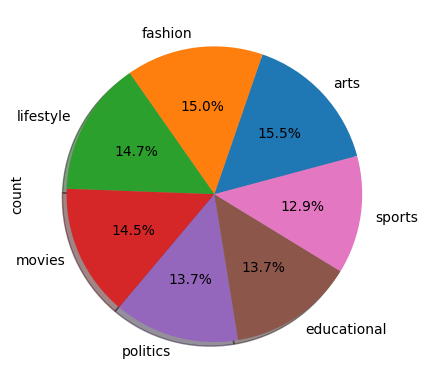

In [22]:
pc_df.plot.pie(y = 'count',
              labels = pc_df['_id'],
              autopct = '%1.1f%%',
              startangle = 15,
              shadow = True,
              legend = False)

In [23]:
pol_sta = posts.aggregate([{'$match': {'Category': 'politics'}},
                            {'$group': {'_id':'$status', 'count': {'$sum':1}}}])

In [24]:
ps_df = pd.DataFrame(list(pol_sta))

In [25]:
ps_df.head()

,_id,count
0,private,148
1,public,126


<Axes: title={'center': 'Número de Posts Públicos e Privados'}, xlabel='_id'>

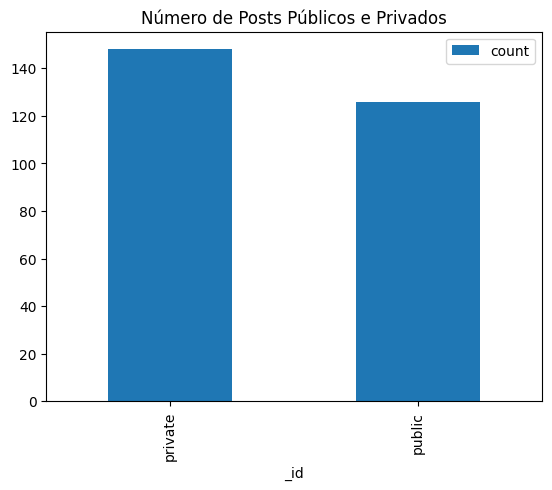

In [26]:
ps_df.plot.bar(x = '_id',
              y = 'count',
              title = 'Número de Posts Públicos e Privados')

In [27]:
datalake.posts.update_many({}, {'$set': {'hour': 0}});
datalake.posts.update_many({}, {'$set': {'year': 0}});

In [28]:
posts.find_one()

{'_id': ObjectId('643200da1b47b58598c9ef9d'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'ligula nec sem duis aliquam',
 'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False,
 'hour': 0,
 'year': 0}

In [29]:
for data in posts.find({}):
    posts.update_one({'_id': data['_id']},
                    {'$set': {'hour': data['creationDate'].split('T')[1].split(':')[0],
                             'year': data['creationDate'].split('T')[0].split('-')[0]}})

In [30]:
posts.find_one()

{'_id': ObjectId('643200da1b47b58598c9ef9d'),
 'status': 'public',
 'creationDate': '2017-07-17T20:05:49Z',
 'allowComments': True,
 'title': 'ligula nec sem duis aliquam',
 'description': 'in felis eu sapien cursus vestibulum proin eu mi nulla ac enim in tempor turpis nec euismod scelerisque quam turpis adipiscing lorem vitae mattis nibh ligula nec sem duis aliquam convallis nunc proin at turpis a pede posuere nonummy integer non velit donec diam neque vestibulum eget vulputate ut ultrices vel augue vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae donec pharetra magna vestibulum aliquet ultrices erat tortor sollicitudin mi sit amet lobortis sapien sapien non mi integer ac neque duis bibendum morbi non',
 'tags': 1,
 'Category': 'lifestyle',
 'filteredPicture': False,
 'hour': '20',
 'year': '2017'}

In [31]:
posts_yr = posts.aggregate([{'$group': {'_id': '$year', 'count': {'$sum':1}}},
                           {'$sort': {'_id.year': 1, 'count': 1}}])

In [32]:
py_df = pd.DataFrame(list(posts_yr))

<Axes: title={'center': 'Número de Posts Por Ano'}, xlabel='_id'>

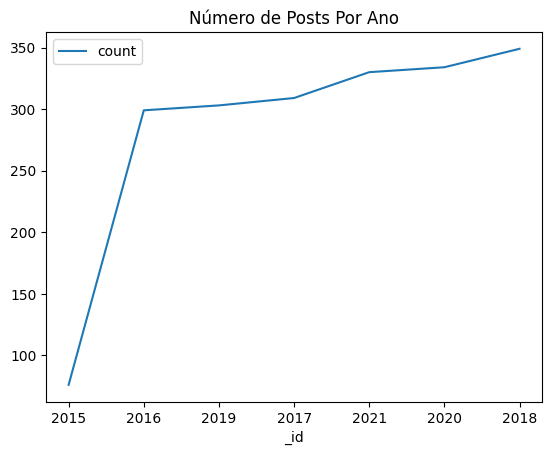

In [33]:
py_df.plot.line(x = '_id',
               y = 'count',
               title = 'Número de Posts Por Ano')

In [34]:
posts_hr = posts.aggregate([{'$group': {'_id': '$hour', 'count': {'$sum':1}}},
                           {'$sort': {'_id.hour': 1, 'count': -1}}])

In [35]:
ph_df = pd.DataFrame(list(posts_hr))

<Axes: title={'center': 'Número de Posts Por Hora'}, xlabel='_id'>

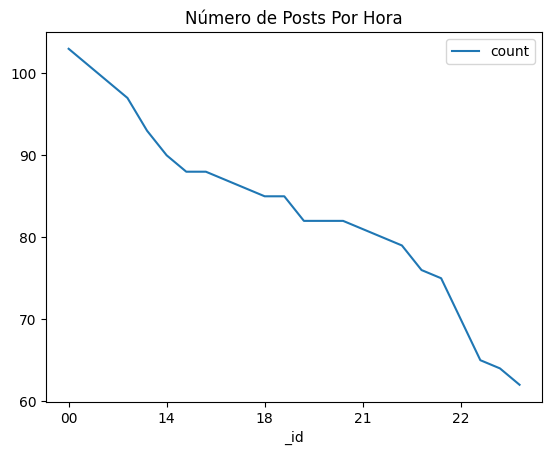

In [36]:
ph_df.plot.line(x = '_id',
               y = 'count',
               title = 'Número de Posts Por Hora')

In [37]:
cat_00 = posts.aggregate([{'$match': {'hour': '00'}},
                            {'$group': {'_id':'$Category', 'count': {'$sum':1}}},
                            {'$sort': {'_id.Category': 1, 'count': -1}}])

In [38]:
c0_df = pd.DataFrame(list(cat_00))

<Axes: title={'center': 'Número de Posts em Hora Cheia'}, xlabel='_id'>

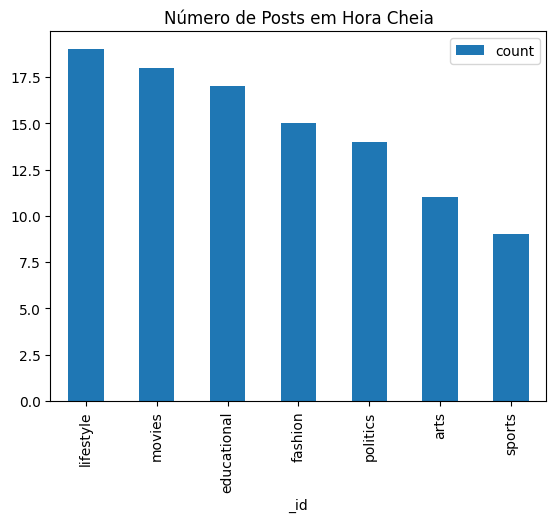

In [39]:
c0_df.plot.bar(x = '_id',
              y = 'count',
              title = 'Número de Posts em Hora Cheia')

In [40]:
datalake.posts.update_many({}, {'$set': {'lenght_of_heading': 0}});

In [41]:
for data in posts.find({}):
    posts.update_one({'_id': data['_id']},
                    {'$set': {'lenght_of_heading': len(data['title'].split(' '))}})

In [42]:
len_titles = posts.aggregate([{'$group': {'_id':'$lenght_of_heading', 'count': {'$sum':1}}},
                            {'$sort': {'_id.lenght_of_heading': 1, 'count': -1}}])

In [43]:
len_titles

In [45]:
title_df = pd.DataFrame(list(len_titles))

In [46]:
title_df.head()

,_id,count
0,3,355
1,4,345
2,1,343
3,5,337
4,6,336


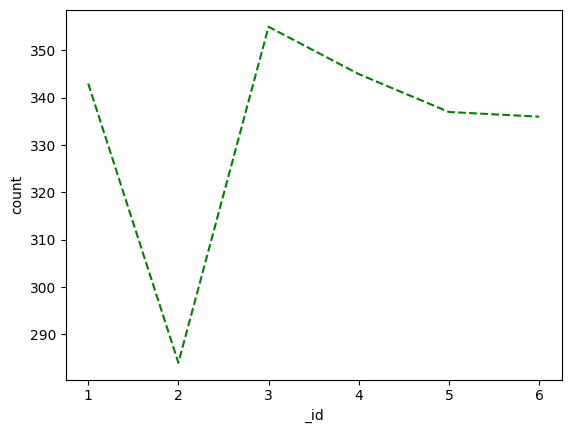

In [47]:
ax = sns.lineplot(x = '_id', y = 'count', data = title_df, color = 'green')
ax.lines[0].set_linestyle('--')
plt.show()